In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Langevin Equation

$$ \gamma \dot{x} = -V^\prime _1 (x) - k_1 y + \sqrt{2k_B T_1 \gamma}ξ_1 $$
$$ \gamma \dot{y} = -V^\prime _2 (y) - k_2 x + \sqrt{2k_B T_2 \gamma}ξ_2 $$

$$ V_1 = \frac{a_1}{2} (x)^2, V_2 = \frac{a_2}{2} (y)^2 $$

$$ \dot{x} = -\frac{a_1}{\gamma} (x) - \frac{k_1}{\gamma} (y) + \sqrt{\frac{2k_B T_1}{\gamma}}ξ_1 $$
$$ \dot{y} = -\frac{a_2}{\gamma} (y) - \frac{k_2}{\gamma} (x) + \sqrt{\frac{2k_B T_2}{\gamma}}ξ_2 $$

Euler Scheme

$$ X_{t+\Delta t} = X_t + f(X_t, t)\Delta t + g(X_t,t)\Delta B_t $$

where $$ \Delta B_t = \mathcal{N}(0, \sqrt\Delta t) $$

### Analytical solution:

$$ dx = -\frac{a_1}{\gamma} (x) dt - \frac{k_1}{\gamma} (y) dt + \sqrt{\frac{2k_B T_1}{\gamma}}ξ_1 dt $$
$$ dy = -\frac{a_2}{\gamma} (y) dt - \frac{k_2}{\gamma} (x) dt + \sqrt{\frac{2k_B T_2}{\gamma}}ξ_2 dt $$

The probability density P(x,t) and P(y,t) follows a Gaussian distribution 

$$ P(x, t) = \frac{1}{\sqrt{2 \pi \sigma ^2 _x}} \exp {- \frac{(x - \mu _x)^2}{2 \sigma ^2 _x}}$$

$$ P(y, t) = \frac{1}{\sqrt{2 \pi \sigma ^2 _y}} \exp {- \frac{(y - \mu _y)^2}{2 \sigma ^2 _y}}$$

$$ \mu_x = (-\frac{a_1}{\gamma} (x_1 - x_0) - \frac{k_1}{\gamma} (y_1 - y_0)) t$$
$$ \sigma ^2 _x = (\frac{2k_B T_1}{\gamma}) t $$

$$ \mu_y = (-\frac{a_2}{\gamma} (y_1 - y_0) - \frac{k_2}{\gamma} (x_1 - x_0)) t$$
$$ \sigma ^2 _y = (\frac{2k_B T_2}{\gamma}) t $$

In [2]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x = 0
    y = 0
    x_traj = []
    y_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x, y
        x_new = x - (pars['a1']/pars['gamma'])*x*pars['delta_t'] - \
        (pars['k1']/pars['gamma'])*y*pars['delta_t'] + \
        np.sqrt((2*pars['Kb']*pars['T1'])/pars['gamma'])*s1
                 
        y_new = y - (pars['a2']/pars['gamma'])*y*pars['delta_t'] - \
        (pars['k2']/pars['gamma'])*x*pars['delta_t'] + \
        np.sqrt((2*pars['Kb']*pars['T2'])/pars['gamma'])*s2
                
        x = x_new
        y = y_new
        
        x_traj.append(x)
        y_traj.append(y)
    return x_traj, y_traj

In [3]:
def euler_n_traj(max_time, pars):
    min_time = 0
    n_time = int((max_time - min_time)/pars['delta_t'] + 1) #n_time = num of evenly spaced samples (ex. 1001 points)
    time = np.linspace(min_time, max_time, n_time) #time(ex. 0 (min time), 0.01, 0.02, ..., 10 (max time)) with n_time no. of data points
    
    x_traj_list = []
    y_traj_list = []
    for i in range(pars['n_realizations']):
        x_traj, y_traj = euler_one_traj(n_time, pars)
        x_traj_list.append(x_traj)
        y_traj_list.append(y_traj)
        
    return x_traj_list, y_traj_list, time

Functions for analytical solution of Pst

In [4]:
def analytical_soln_x(times, start, end, pars):
    prob_list = []
    x = np.linspace(start, end, 100)
    x_shift = np.roll(x, shift = 1)
    y = np.linspace(start, end, 100)
    y_shift = np.roll(y, shift = 1)
    
    for x_, y_, x_shift_, y_shift_ in zip(x, y, x_shift, y_shift):
        mean = (((-pars['a1']/pars['gamma'])*(x_ - x_shift_)) - ((pars['k1']/pars['gamma'])*(y_ - y_shift_))) *times
        var = ((2*pars['Kb']*pars['T1'])/pars['gamma'])*times
        exponent = np.exp(-((x_ - mean)**2) / (2*var)) 
        prob = exponent/ np.sqrt(2*np.pi*var)
        prob_list.append(prob)
    return prob_list[1:], x[1:]

def analytical_soln_y(times, start, end, pars):
    prob_list = []
    x = np.linspace(start, end, 100)
    x_shift = np.roll(x, shift = 1)
    y = np.linspace(start, end, 100)
    y_shift = np.roll(y, shift = 1)
    
    for x_, y_, x_shift_, y_shift_ in zip(x, y, x_shift, y_shift):
        mean = (((-pars['a2']/pars['gamma'])*(y_ - y_shift_)) - ((pars['k2']/pars['gamma'])*(x_ - x_shift_))) *times
        var = ((2*pars['Kb']*pars['T2'])/pars['gamma'])*times
        exponent = np.exp(-((y_ - mean)**2) / (2*var)) 
        prob = exponent/ np.sqrt(2*np.pi*var)
        prob_list.append(prob)
    return prob_list[1:], x[1:]

def obtain_last_element_traj(x_traj_list, y_traj_list):
    x_list = []
    y_list = []
    for x in x_traj_list:
        last_elementx = x[-1]
        x_list.append(last_elementx)
        
    for y in y_traj_list:
        last_elementy = y[-1]
        y_list.append(last_elementy)
    
    return x_list, y_list

Plot probability distributions

In [5]:
#paramaters
pars = {}
pars['a1'] = 1
pars['k1'] = 1
pars['T1'] = 100
pars['a2'] = 1
pars['k2'] = 1
pars['T2'] = 100

pars['gamma'] = 1
pars['delta_t'] = 0.01
pars['Kb'] = 1.38*np.exp(-23)

## T1 = 100, T2 = 100

In [6]:
#for t = 1s
pars['T1'] = 100
pars['T2'] = 100
pars['n_realizations'] = 1000
analytical_x1s, x_1s = analytical_soln_x(1, -0.0004, 0.0004, pars)
analytical_y1s, y_1s = analytical_soln_y(1, -0.0004, 0.0004, pars)
x_traj_list, y_traj_list, time = euler_n_traj(1, pars)
x_list, y_list = obtain_last_element_traj(x_traj_list, y_traj_list)

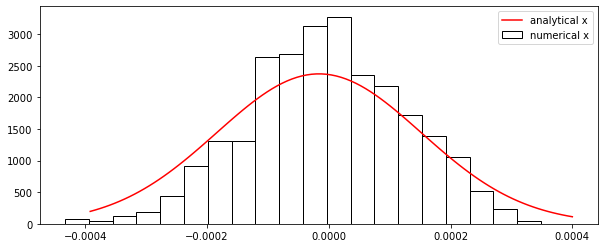

In [7]:
plt.figure(figsize=(10,4))
plt.hist(x_list, density = True, edgecolor = 'black', color = 'white', bins = 20, label = 'numerical x')
plt.plot(x_1s, analytical_x1s, color = 'red', label = 'analytical x')
plt.legend()
plt.show()

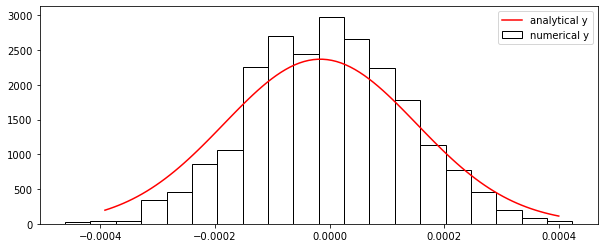

In [8]:
plt.figure(figsize=(10,4))
plt.hist(y_list, density = True, edgecolor = 'black', color = 'white', bins = 20, label = 'numerical y')
plt.plot(y_1s, analytical_y1s, color = 'red', label = 'analytical y')
plt.legend()
plt.show()

### T1 = 100, T2 = 600

In [9]:
#for t = 1s
pars['T1'] = 100
pars['T2'] = 600
pars['n_realizations'] = 1000
analytical_x1s, x_1s = analytical_soln_x(1, -0.0006, 0.0006, pars)
analytical_y1s, y_1s = analytical_soln_y(1, -0.0010, 0.0010, pars)
x_traj_list, y_traj_list, time = euler_n_traj(1, pars)
x_list, y_list = obtain_last_element_traj(x_traj_list, y_traj_list)

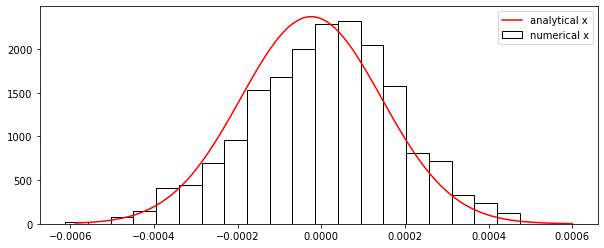

In [10]:
plt.figure(figsize=(10,4))
plt.hist(x_list, density = True, edgecolor = 'black', color = 'white', bins = 20, label = 'numerical x')
plt.plot(x_1s, analytical_x1s, color = 'red', label = 'analytical x')
plt.legend()
plt.show()

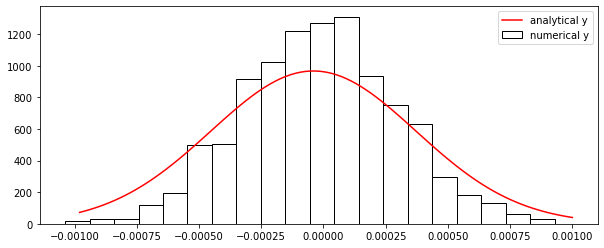

In [11]:
plt.figure(figsize=(10,4))
plt.hist(y_list, density = True, edgecolor = 'black', color = 'white', bins = 20, label = 'numerical y')
plt.plot(y_1s, analytical_y1s, color = 'red', label = 'analytical y')
plt.legend()
plt.show()